## **Importing all necessary libraries**

In [1]:
!pip install split_folders

In [2]:
import numpy as np
from glob import glob
import random
import splitfolders
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
os.makedirs('output1')
os.makedirs('output1/train')
os.makedirs('output1/val')
os.makedirs('output1/test')

loc = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"

splitfolders.ratio(loc,output ="output1",ratio = (0.80,.1,.1))

Copying files: 4188 files [00:08, 496.19 files/s] 


In [4]:
train_path = '/kaggle/working/output1/train'
val_path = '/kaggle/working/output1/val'

In [5]:
IMAGE_SIZE = [224, 224]

In [6]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Model Training**

In [7]:
model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in model.layers:
    layer.trainable = False

In [9]:
folders = glob('/kaggle/working/output1/train/*')

In [10]:
print(folders)
print(len(folders))

['/kaggle/working/output1/train/Blight', '/kaggle/working/output1/train/Gray_Leaf_Spot', '/kaggle/working/output1/train/Common_Rust', '/kaggle/working/output1/train/Healthy']
4


In [11]:
x = Flatten()(model.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
training_set = train_datagen.flow_from_directory('/kaggle/working/output1/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3348 images belonging to 4 classes.


In [15]:
val_set = test_datagen.flow_from_directory('/kaggle/working/output1/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 417 images belonging to 4 classes.


In [16]:
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

/tmp/ipykernel_853/4288324285.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
105/105 [==============================] - 46s 390ms/step - loss: 0.5519 - accuracy: 0.8130 - val_loss: 509.5416 - val_accuracy: 0.8561
Epoch 2/10
105/105 [==============================] - 40s 378ms/step - loss: 0.4828 - accuracy: 0.8719 - val_loss: 318.3735 - val_accuracy: 0.8753
Epoch 3/10
105/105 [==============================] - 40s 382ms/step - loss: 0.2671 - accuracy: 0.9188 - val_loss: 337.0410 - val_accuracy: 0.8753
Epoch 4/10
105/105 [==============================] - 40s 379ms/step - loss: 0.2651 - accuracy: 0.9161 - val_loss: 0.3103 - val_accuracy: 0.8945
Epoch 5/10
105/105 [==============================] - 40s 380ms/step - loss: 0.3087 - accuracy: 0.9200 - val_loss: 0.3474 - val_accuracy: 0.8849
Epoch 6/10
105/105 [==============================] - 41s 387ms/step - loss: 0.2351 - accuracy: 0.9328 - val_loss: 0.3368 - val_accuracy: 0.8849
Epoch 7/10
105/105 [==============================] - 40s 382ms/step - loss: 0.2633 - accuracy: 0.9355 - val_loss: 0.3624 - 

In [17]:
print('Train accuracy:', r.history['accuracy'][-1]*100)
print('val accuracy:', r.history["val_accuracy"][-1]*100)

Train accuracy: 94.74313259124756
val accuracy: 89.92805480957031


In [18]:
test_data = ImageDataGenerator(rescale = 1./255)
test_set = test_data.flow_from_directory('/kaggle/working/output1/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 423 images belonging to 4 classes.


In [19]:
print("Validation Accuracy",model.evaluate(val_set))
print("Testing Accuracy",model.evaluate(test_set))

14/14 [==============================] - 1s 74ms/step - loss: 134.8962 - accuracy: 0.8969
Validation Accuracy [134.8961639404297, 0.8968824744224548]
14/14 [==============================] - 2s 130ms/step - loss: 1797.7976 - accuracy: 0.8676
Testing Accuracy [1797.797607421875, 0.8676123023033142]


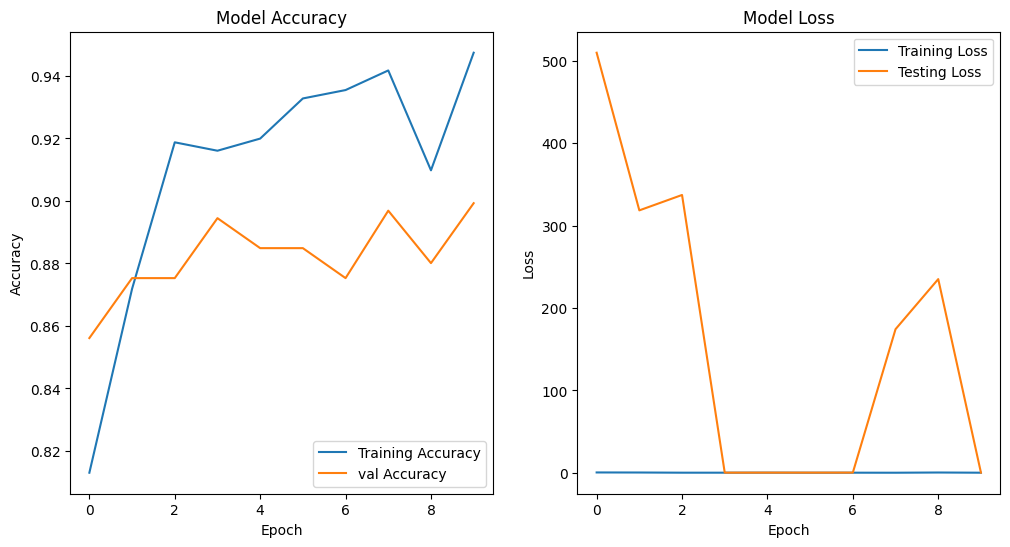

In [20]:
def way3(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(r.history['accuracy'], label='Training Accuracy')
    ax1.plot(r.history['val_accuracy'], label='val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(r.history['loss'], label='Training Loss')
    ax2.plot(r.history['val_loss'], label='Testing Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')

    plt.show()

Graphs = way3(r)
Graphs

## **We can save our model**

In [21]:

model.save('model_vgg16.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Check whether it is working or not**

In [22]:
from tensorflow.keras.models import load_model
img_path = '/kaggle/input/corn-leaf/Corn_leaf.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

In [23]:
preds = model.predict(x)

1/1 [==============================] - 0s 173ms/step


In [24]:
preds

array([[0., 1., 0., 0.]], dtype=float32)

In [25]:
classes = ['Blight','Gray_Leaf_Spot','Common_Rust','Healthy']

In [26]:
MaxPosition=np.argmax(preds)  
prediction_label=classes[MaxPosition]
print(prediction_label) 

Gray_Leaf_Spot


In [27]:
import matplotlib.image as mpimg
import plotly.express as px
%matplotlib inline
img=mpimg.imread(img_path)
fig = px.imshow(img)
fig.show()